In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import piecewise_regression
import pywt
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

#Functions
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

def thresholding(coeffs, threshold):
    return [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

def getStressStrainCurve(data_list, thickness_info = True, thickness_list = None, cut_off_load = 2):
    # convert in to um
    for i in range(len(data_list)):
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000
        # create stress column which is load / area, the area is 19.635 mm^2
        data_list[i]['stress (bar)'] = data_list[i]['Ch:Load (N)'] / 19.635 *10

    if thickness_info:
        thickness = thickness_list
        x_axis = 'strain'
        x_axis_label = 'Strain'
        # convert in to um
        for i in range(len(data_list)): 
            # create strain column which is displacement / thickness, the thickness is shown above
            data_list[i]['strain'] = data_list[i]['S:LVDT (um)'] / thickness[i]
    else:
        x_axis = 'S:LVDT (um)'
        x_axis_label = 'Displacement (um)'
    data_list_cleaned = []

    # Plot these in the same graph to compare them
    plt.figure(figsize=(8, 6))
    for i in range(len(data_list)):
        data_name = namestr(data_list[i], globals())
        data = data_list[i][data_list[i]['Ch:Load (N)'] > cut_off_load]
        data = data.loc[:data['Ch:Load (N)'].idxmax()]
        # shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data[x_axis] = data[x_axis] - data[x_axis].iloc[0]
        data_list_cleaned.append(data)
        plt.plot(data[x_axis], data['stress (bar)'], label=data_name)
    plt.xlabel(x_axis_label)
    plt.ylabel('Stress (bar)')
    plt.legend(loc='upper left')
    plt.show()

def denoiseData_SavitskyGolay(data_list, cut_off_load = 2): #need to add to the dataframe to use the denoised data
    for i in range(len(data_list)):
        # Apply Savitzky-Golay filter
        window_length = 400  # Length of the filter window (must be a positive odd integer)
        polyorder = 3       # Order of the polynomial used to fit the samples (must be less than window_length)

        # Align strain to 0
        data = data_list[i][data_list[i]['Ch:Load (N)'] > cut_off_load]
        data = data.loc[:data['Ch:Load (N)'].idxmax()]
        # Shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data['strain'] = data['strain'] - data['strain'].iloc[0]
        data["stress (bar)"] = data["stress (bar)"] - data['strain'].iloc[0]

        data["denoised stress (bar)"] = savgol_filter(data["stress (bar)"], window_length, polyorder)
        data["denoised stress (bar)"] = data["denoised stress (bar)"].rolling(window=120).mean()
        
        # Plotting the results
        plt.figure(figsize=(10, 6))
        plt.plot(data['strain'], data["stress (bar)"], label='Noisy data')
        plt.plot(data['strain'], data["denoised stress (bar)"], label='Smoothed data', color='red')
        plt.legend()
        plt.xlabel('strain')
        plt.ylabel('stress (bar)')
        plt.title('Savitzky-Golay Filter Smoothing')
        plt.show()

def denoiseData_GaussianFilter(data_list, cut_off_load = 2):
    for i in range(len(data_list)):
        # Align strain to 0
        data = data_list[i][data_list[i]['Ch:Load (N)'] > cut_off_load]
        data = data.loc[:data['Ch:Load (N)'].idxmax()]
        # Shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data['strain'] = data['strain'] - data['strain'].iloc[0]
        data["stress (bar)"] = data["stress (bar)"] - data['strain'].iloc[0]

        sigma = 200  # standard deviation for Gaussian kernel
        y_smooth = scipy.ndimage.gaussian_filter1d(data["stress (bar)"], sigma, mode='nearest')

        # Plotting the results
        plt.figure(figsize=(10, 6))
        plt.plot(data['strain'], data["stress (bar)"], label='Noisy data')
        plt.plot(data['strain'], y_smooth, label='Smoothed data', color='red')
        plt.legend()
        plt.xlabel('strain')
        plt.ylabel('stress (bar)')
        plt.title('Gaussian Filter Smoothing')
        plt.show()

def validDataCheck_Correlation(data_list):
    df = pd.DataFrame()
    for i in range(len(data_list)):
        data_name = namestr(data_list[i], globals())
        df[data_name] = data_list[i]["stress (bar)"]
    pearson_corr = df.corr(method='pearson')

    print(pearson_corr)
    pearson_corr = pearson_corr.values.flatten().tolist()
    
    x = True
    for i in range(len(pearson_corr)):
        if math.ceil(pearson_corr[i]) < 0.95:
                x = False
    return x

def segmentingTheCurve_PiecewiseRegression(data_list, cut_off_load = 2):
    for i in range(len(data_list)):

        data = data_list[i][data_list[i]['Ch:Load (N)'] > cut_off_load]
        data = data.loc[:data['Ch:Load (N)'].idxmax()]
        # shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data['strain'] = data['strain'] - data['strain'].iloc[0]
        data["stress (bar)"] = data["stress (bar)"] - data['strain'].iloc[0]

        
        pw_fit = piecewise_regression.Fit(list(data['strain']), list(data['stress (bar)']), n_breakpoints=6)

        #
        pw_fit.plot_fit(color="red", linewidth=2)
        pw_fit.plot_data(color="grey", s=1)
        pw_fit.plot_breakpoints()
        pw_fit.plot_breakpoint_confidence_intervals()
        plt.title("Piecewise Regression")
        plt.xlabel("Strain")
        plt.ylabel("Stress (bar)")
        plt.show()
        pw_fit.summary()
        
        pw_results = pw_fit.get_results()
        breakpoint1 = pw_results['estimates']['breakpoint1']['estimate']
        breakpoint2 = pw_results['estimates']['breakpoint2']['estimate']
        breakpoint6 = pw_results['estimates']['breakpoint6']['estimate']

    
def segmentingTheCurve_SavitskyGolay(data_list, cut_off_load = 2):
    for i in range(len(data_list)):
        # Apply Savitzky-Golay filter
        window_length = 400  # Length of the filter window (must be a positive odd integer)
        polyorder = 3       # Order of the polynomial used to fit the samples (must be less than window_length)

        #Align strain to 0
        data = data_list[i][data_list[i]['Ch:Load (N)'] > cut_off_load]
        data = data.loc[:data['Ch:Load (N)'].idxmax()]
        # shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data['strain'] = data['strain'] - data['strain'].iloc[0]
        data["stress (bar)"] = data["stress (bar)"] - data['strain'].iloc[0]

        y_smooth = savgol_filter(data["stress (bar)"], window_length, polyorder)
        dy_smooth = savgol_filter(data["stress (bar)"], window_length, polyorder, deriv=1)

        x = data['strain']
        y = data["stress (bar)"]

        """
        Need to find a way to to use the derivative to find the changepoints
        # Find Minima
        inverted_y = -y_smooth
        minima_indices, _ = find_peaks(inverted_y)

        # Get the local minima coordinates
        x_minima = x[minima_indices]
        """
        
        # Plot the original and smoothed data
        plt.figure(figsize=(12, 12))
        plt.subplot(211)
        plt.plot(x, y, label='Original Data')
        plt.plot(x, y_smooth, label='Smoothed Data')
        plt.legend()
        plt.subplot(212)
        plt.plot(x, dy_smooth, label='Derivative of Smoothed Data')
        plt.legend()
        plt.show()

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import piecewise_regression
import pywt
from scipy.signal import savgol_filter, find_peaks
from sklearn.linear_model import LinearRegression

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

def thresholding(coeffs, threshold):
    return [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

def interpretData(data_list, thickness_info = True, thickness_list = None):
    #FIRST derive stress strain curve from data list
    
    # convert in to um
    for i in range(len(data_list)):
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000
        # create stress column which is load / area, the area is 19.635 mm^2
        data_list[i]['stress (bar)'] = data_list[i]['Ch:Load (N)'] / 19.635 *10

    if thickness_info:
        thickness = thickness_list
        x_axis = 'strain'
        x_axis_label = 'Strain'
        # convert in to um
        for i in range(len(data_list)): 
             # create strain column which is displacement / thickness, the thickness is shown above
             data_list[i]['strain'] = data_list[i]['S:LVDT (um)'] / thickness[i]
    else:
        x_axis = 'S:LVDT (um)'
        x_axis_label = 'Displacement (um)'

    consolidatedData = []

    for i in range(len(data_list)):
        data_name = namestr(data_list[i], globals())
        data = data_list[i][data_list[i]['Ch:Load (N)'] > 2]
        data = data.loc[:data['Ch:Load (N)'].idxmax()]
        # shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data[x_axis] = data[x_axis] - data[x_axis].iloc[0]
        data["stress (bar)"] = data["stress (bar)"] - data[x_axis].iloc[0]

        #SECOND denoise the data
        window_length = 400
        polyorder = 3
        data["denoised stress (bar)"] = savgol_filter(data["stress (bar)"], window_length, polyorder)
        data["denoised stress (bar)"] = data["denoised stress (bar)"].rolling(window=120).mean()

        
        Data = {x_axis:list(data[x_axis]), "stress (bar)":list(data["denoised stress (bar)"])}
        df = pd.DataFrame(Data)
        consolidatedData.append(df.dropna())

    mechanicalProperties = []
    validDataCheck = []

    #THIRD perform piecewise regression
    for i in range(len(consolidatedData)):
        #THIRD check data quality

        dataset = consolidatedData[i]
        model = LinearRegression()
        model.fit(dataset[[x_axis]].values, np.log(dataset['stress (bar)'].values))
        r_squared = model.score(dataset[[x_axis]].values, np.log(dataset['stress (bar)'].values))
        print(r_squared)

        #is_increasing = all(dataset[x_axis].iloc[i] >= dataset['stress (bar)'].iloc[i - 200] for i in range(200, len(df),200))
        #print(is_increasing)
        
        if r_squared < 1: #0.9055?
            pw_fit = piecewise_regression.Fit(list(consolidatedData[i][x_axis]), list(consolidatedData[i]['stress (bar)']), n_breakpoints=6)
            pw_results = pw_fit.get_results()
            breakpoint1 = pw_results['estimates']['breakpoint1']['estimate']
            breakpoint2 = pw_results['estimates']['breakpoint2']['estimate']
            breakpoint6 = pw_results['estimates']['breakpoint6']['estimate']

            #FOURTH extract mechanical properties
            elasticRegion = consolidatedData[i][consolidatedData[i][x_axis] <= breakpoint1]       
            plateauRegion = consolidatedData[i][(breakpoint1 <= consolidatedData[i][x_axis]) & (consolidatedData[i][x_axis] <= breakpoint2)]
            densificationRegion = consolidatedData[i][consolidatedData[i][x_axis] >= breakpoint6] 
        
            #elastic region
            modelElastic = LinearRegression()
            modelElastic.fit(elasticRegion[x_axis].values.reshape(-1, 1), elasticRegion['stress (bar)'].values)
            elasticModulus = modelElastic.coef_[0]
            yieldStrength = modelElastic.predict(breakpoint1.reshape(1,-1))
            predElastic = modelElastic.predict(elasticRegion[[x_axis]])

            #plateau region
            modelPlateau = LinearRegression()
            modelPlateau.fit(plateauRegion[x_axis].values.reshape(-1, 1), plateauRegion['stress (bar)'].values)
            slopePlateau = modelPlateau.coef_[0]
            interceptPlateau = modelPlateau.intercept_

            #densification region
            modelDensification = LinearRegression()
            modelDensification.fit(densificationRegion[x_axis].values.reshape(-1, 1), densificationRegion['stress (bar)'].values)
            slopeDensification = modelDensification.coef_[0]
            interceptDensification = modelDensification.intercept_

            changepoint = (interceptDensification - interceptPlateau) / (slopePlateau - slopeDensification)
            xPlateau = consolidatedData[i][(breakpoint1 <= consolidatedData[i][x_axis]) & (consolidatedData[i][x_axis] <= changepoint)]
            xDensification = consolidatedData[i][changepoint <= consolidatedData[i][x_axis]]
            predPlateau = modelPlateau.predict(xPlateau[[x_axis]])
            predDensification = modelDensification.predict(xDensification[[x_axis]])

            plt.scatter(consolidatedData[i][x_axis], consolidatedData[i]['stress (bar)'], color = 'lightgrey', label='Smoothed Data')
            plt.plot(elasticRegion[x_axis], predElastic, color = 'blue',  label='Elastic Region')
            plt.plot(xPlateau[x_axis], predPlateau, color = 'orange', label="Plateau Region")
            plt.plot(xDensification[x_axis], predDensification, color = 'green', label="Densificaiton Region")
            plt.xlabel(x_axis_label)
            plt.ylabel('Stess (bar)')
            data_name = namestr(data_list[i], globals())
            plt.title(data_name)
            plt.legend()
            plt.show()

            dict = {"Elastic Modulus":elasticModulus, "Yield Strength":yieldStrength, "Changepoint":changepoint, "Slope Plateau":slopePlateau}
            mechanicalProperties.append(dict)

        else:
            mechanicalProperties.append(None)

    
    return mechanicalProperties
    

    #FIFTH check the validity of the data

0.8548750476853809


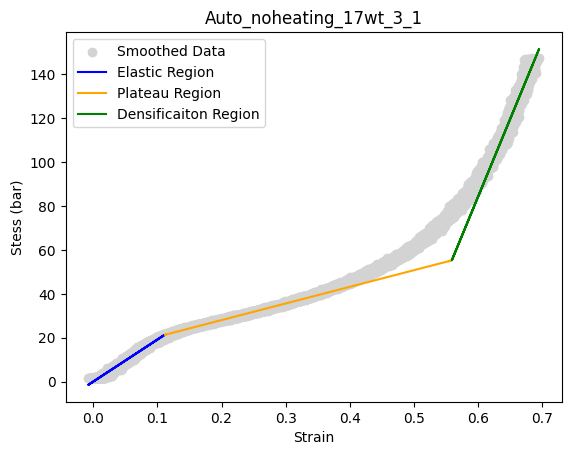

0.8576379704727843


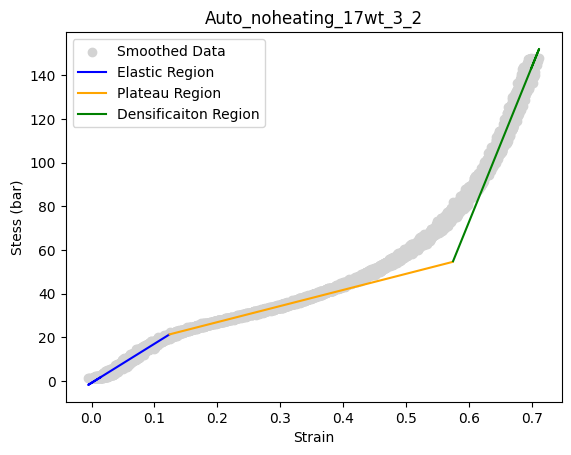

0.8615447346400009


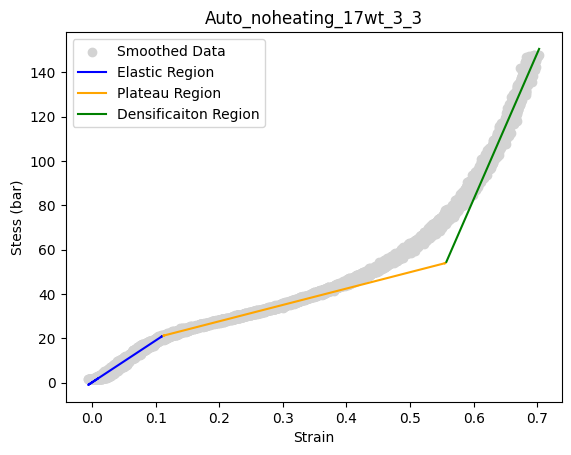

0.8615679807806753


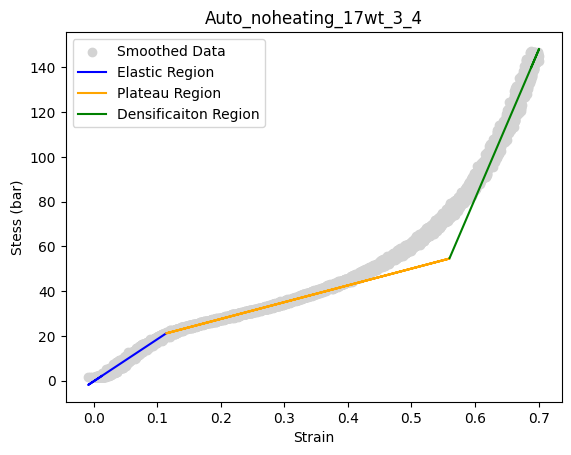

[{'Elastic Modulus': 191.48250415109428,
  'Yield Strength': array([21.27410251]),
  'Changepoint': 0.5594375483016387,
  'Slope Plateau': 75.7710000359748},
 {'Elastic Modulus': 178.98266282011048,
  'Yield Strength': array([21.38389155]),
  'Changepoint': 0.5740652548623615,
  'Slope Plateau': 73.74542336854789},
 {'Elastic Modulus': 188.77426123436027,
  'Yield Strength': array([21.12544678]),
  'Changepoint': 0.5563263913971297,
  'Slope Plateau': 73.76799451182688},
 {'Elastic Modulus': 187.868781323993,
  'Yield Strength': array([21.14764795]),
  'Changepoint': 0.5596760030945916,
  'Slope Plateau': 75.0187429531855}]

In [123]:
#Good Data
Auto_noheating_17wt_3_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-1-240212_02122024_180801.csv')
Auto_noheating_17wt_3_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-2-240212_02122024_181028.csv')
Auto_noheating_17wt_3_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-3-240212_02122024_181307.csv')
Auto_noheating_17wt_3_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-4-240212_02122024_181657.csv')

data_list_17_3 = [Auto_noheating_17wt_3_1, Auto_noheating_17wt_3_2, Auto_noheating_17wt_3_3, Auto_noheating_17wt_3_4]
thickness_17_3 = [110,105,105,105]

interpretData(data_list_17_3, thickness_info = True, thickness_list = thickness_17_3)

0.9509755695461976


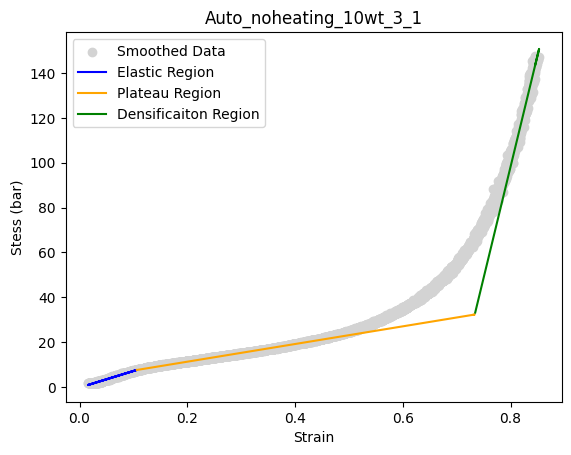

0.9429552735858003


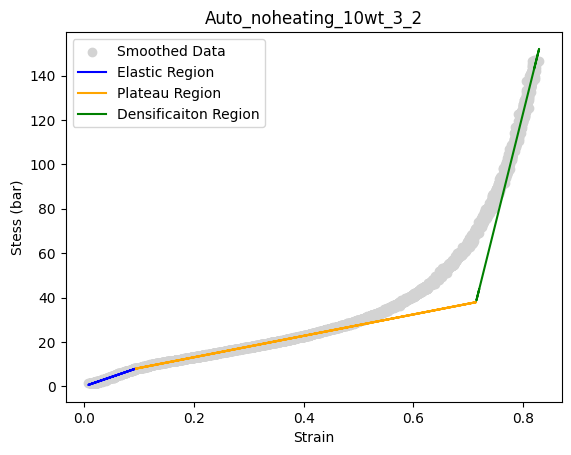

0.9375704745459688


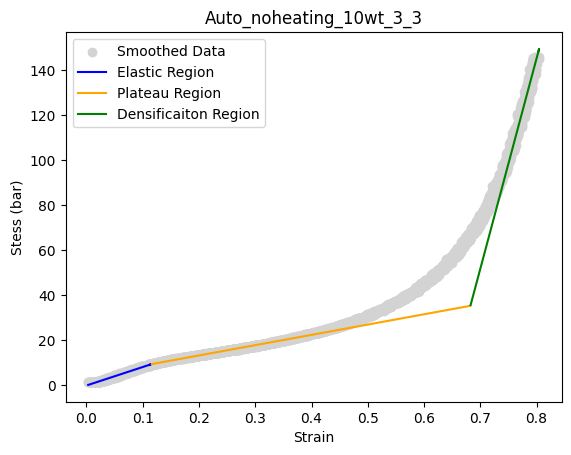

0.9398821609244651


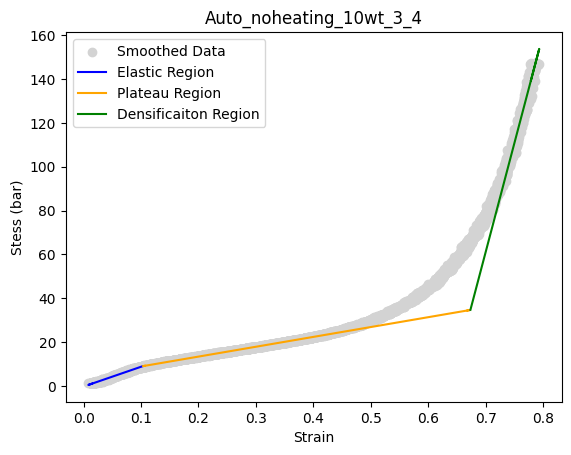

[{'Elastic Modulus': 74.02736198942996,
  'Yield Strength': array([7.56576908]),
  'Changepoint': 0.7334011396400386,
  'Slope Plateau': 39.4160119885195},
 {'Elastic Modulus': 84.62237811615105,
  'Yield Strength': array([7.95608379]),
  'Changepoint': 0.7144246120993503,
  'Slope Plateau': 48.21905225151477},
 {'Elastic Modulus': 82.10090222337973,
  'Yield Strength': array([9.4682804]),
  'Changepoint': 0.6823784750494055,
  'Slope Plateau': 45.73756371293328},
 {'Elastic Modulus': 90.1690705234979,
  'Yield Strength': array([9.1128426]),
  'Changepoint': 0.6735102001145747,
  'Slope Plateau': 44.89266377939676}]

In [124]:
Auto_noheating_10wt_3_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-10-3-1-240212_02122024_160514.csv')
Auto_noheating_10wt_3_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-10-3-2-240212_02122024_160815.csv')
Auto_noheating_10wt_3_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-10-3-3-240212_02122024_161038.csv')
Auto_noheating_10wt_3_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-10-3-4-240212_02122024_161307.csv')

data_list_10_3 = [Auto_noheating_10wt_3_1, Auto_noheating_10wt_3_2, Auto_noheating_10wt_3_3, Auto_noheating_10wt_3_4]
thickness_10_3 = [109,113,107,106]

interpretData(data_list_10_3, thickness_info = True, thickness_list = thickness_10_3)

0.9466596778906492


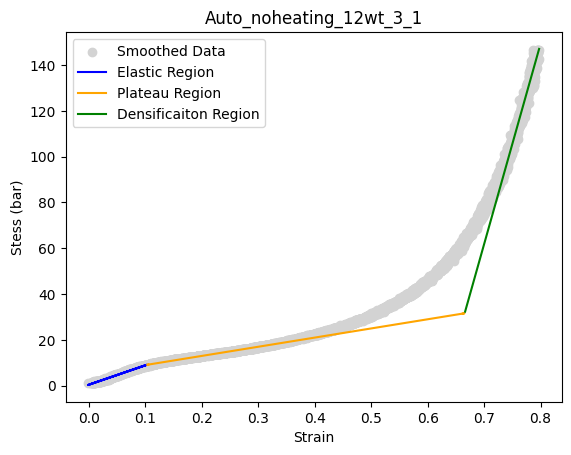

0.9431257811667064


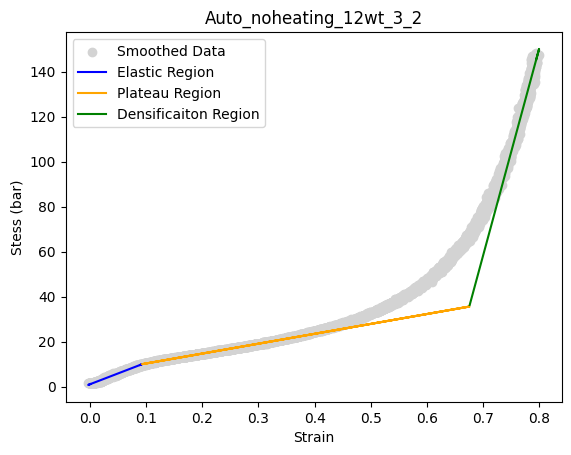

0.9326094311868922


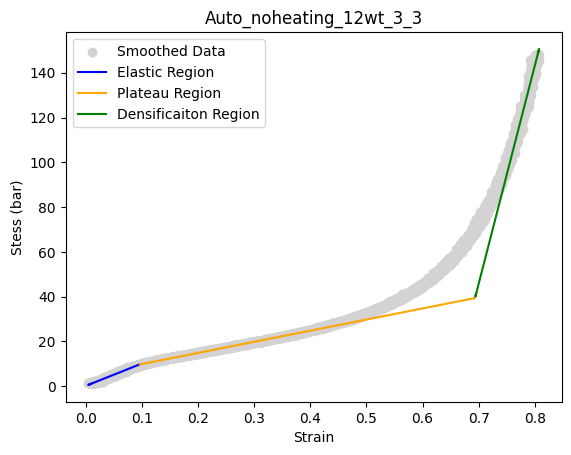

0.9322098999302868


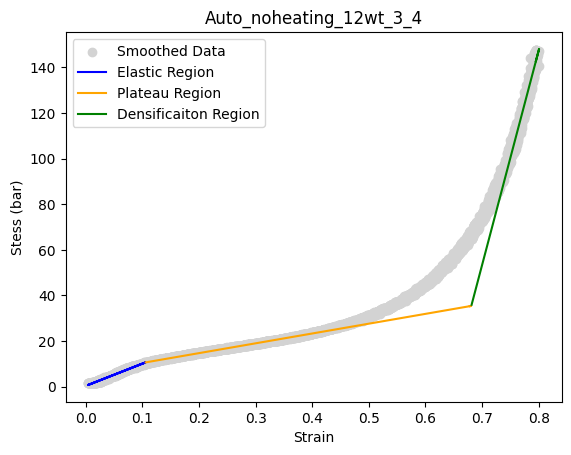

[{'Elastic Modulus': 84.67405963920494,
  'Yield Strength': array([9.10289029]),
  'Changepoint': 0.6655293821649975,
  'Slope Plateau': 40.00217133264865},
 {'Elastic Modulus': 96.14519589096854,
  'Yield Strength': array([10.027355]),
  'Changepoint': 0.6751180040145256,
  'Slope Plateau': 43.974738723389656},
 {'Elastic Modulus': 99.90434411907346,
  'Yield Strength': array([9.68526782]),
  'Changepoint': 0.6934949604177454,
  'Slope Plateau': 49.61650306846248},
 {'Elastic Modulus': 97.51515771439719,
  'Yield Strength': array([10.65369866]),
  'Changepoint': 0.6809650529212588,
  'Slope Plateau': 43.029734991178735}]

In [125]:
Auto_noheating_12wt_3_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-12-3-1-240212_02122024_161808.csv')
Auto_noheating_12wt_3_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-12-3-2-240212_02122024_162105.csv')
Auto_noheating_12wt_3_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-12-3-3-240212_02122024_162358.csv')
Auto_noheating_12wt_3_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-12-3-4-240212_02122024_162658.csv')

data_list_12_3 = [Auto_noheating_12wt_3_1, Auto_noheating_12wt_3_2, Auto_noheating_12wt_3_3, Auto_noheating_12wt_3_4]
thickness_12_3 = [107,110,112,112]

interpretData(data_list_12_3, thickness_info = True, thickness_list = thickness_12_3)

0.9050260770425115


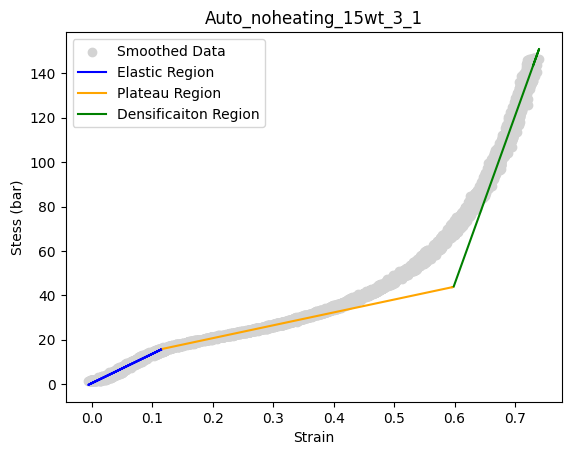

0.9019262464211487


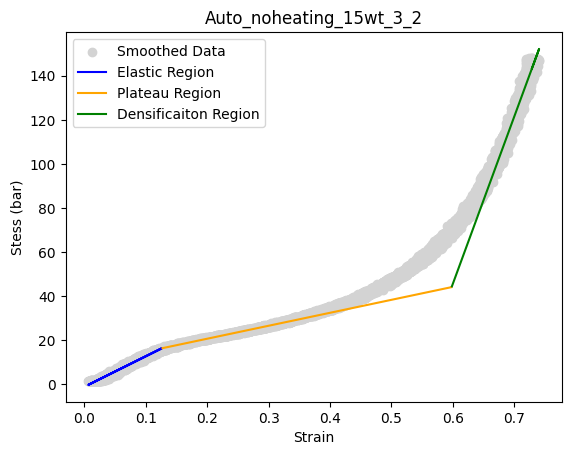

0.8986062642145966


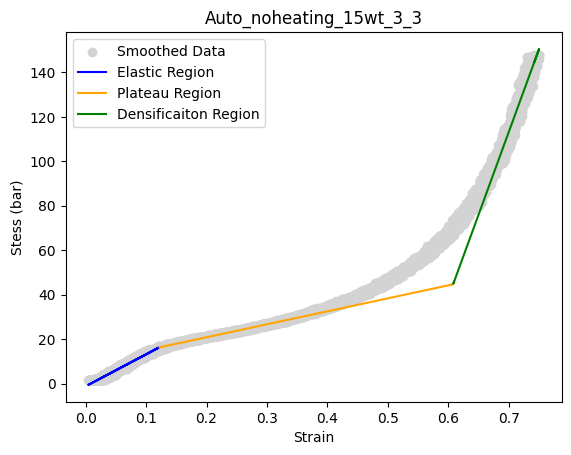

0.8984736106367733


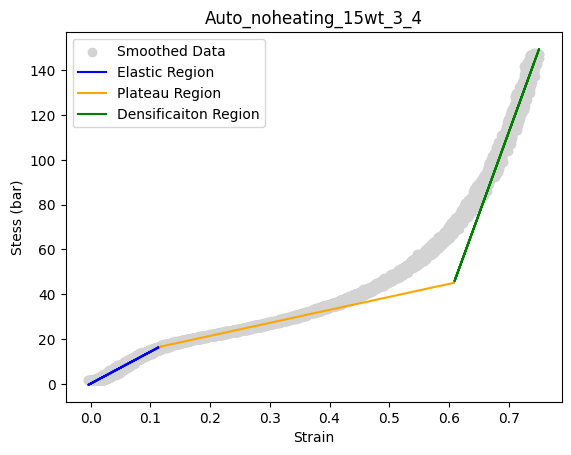

[{'Elastic Modulus': 132.08490980152493,
  'Yield Strength': array([15.84357078]),
  'Changepoint': 0.5984452976999641,
  'Slope Plateau': 57.962802294000745},
 {'Elastic Modulus': 138.7154999189874,
  'Yield Strength': array([16.29207702]),
  'Changepoint': 0.598018910061708,
  'Slope Plateau': 58.85689440773757},
 {'Elastic Modulus': 143.8252842628826,
  'Yield Strength': array([16.27446058]),
  'Changepoint': 0.6077211312513,
  'Slope Plateau': 58.396232934084},
 {'Elastic Modulus': 142.39823161620038,
  'Yield Strength': array([16.49003645]),
  'Changepoint': 0.6081976807256421,
  'Slope Plateau': 57.992742934628225}]

In [126]:
Auto_noheating_15wt_3_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-15-3-1-240212_02122024_175519.csv')
Auto_noheating_15wt_3_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-15-3-2-240212_02122024_175755.csv')
Auto_noheating_15wt_3_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-15-3-3-240212_02122024_180046.csv')
Auto_noheating_15wt_3_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-15-3-4-240212_02122024_180316.csv')

data_list_15_3 = [Auto_noheating_15wt_3_1, Auto_noheating_15wt_3_2, Auto_noheating_15wt_3_3, Auto_noheating_15wt_3_4]
thickness_15_3 = [103,105,105,105]

interpretData(data_list_15_3, thickness_info = True, thickness_list = thickness_15_3)

0.9170049415450569


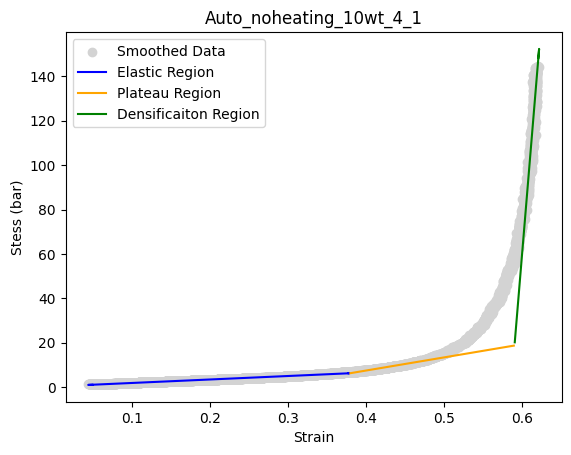

0.9474973849069581


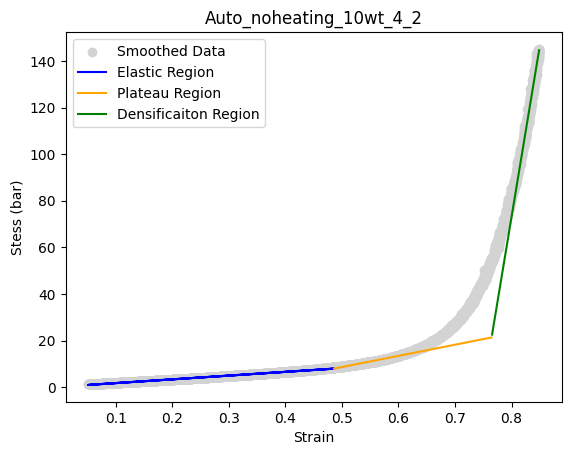

0.9457416578006618


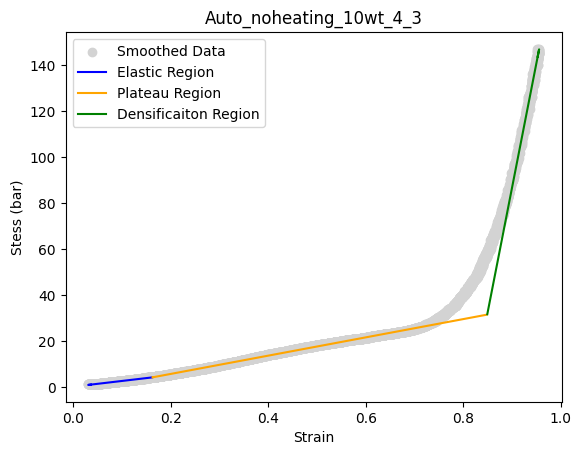

[{'Elastic Modulus': 15.689917163532076,
  'Yield Strength': array([6.25808971]),
  'Changepoint': 0.5901488983438384,
  'Slope Plateau': 59.227312868462555},
 {'Elastic Modulus': 16.07771444922427,
  'Yield Strength': array([7.94459156]),
  'Changepoint': 0.7647773835704337,
  'Slope Plateau': 47.94139302976258},
 {'Elastic Modulus': 24.88067503558954,
  'Yield Strength': array([4.30446284]),
  'Changepoint': 0.8489157686788525,
  'Slope Plateau': 39.70219703750541}]

In [127]:
Auto_noheating_10wt_4_1 = pd.read_csv('Data/compression 4/AutoNoheating-10-4-1-240223_02232024_161809.csv') #can't find Young's Modulus in og data
Auto_noheating_10wt_4_2 = pd.read_csv('Data/compression 4/AutoNoheating-10-4-2-240223_02232024_162119.csv') #can't find Young's Modulus in og data
Auto_noheating_10wt_4_3 = pd.read_csv('Data/compression 4/AutoNoheating-10-4-3-240223_02232024_162456.csv')

data_list_10_4 = [Auto_noheating_10wt_4_1, Auto_noheating_10wt_4_2, Auto_noheating_10wt_4_3]
thickness_10_4 = [105,105,105]

interpretData(data_list_10_4, thickness_info = True, thickness_list = thickness_10_4)

0.9238955495339454


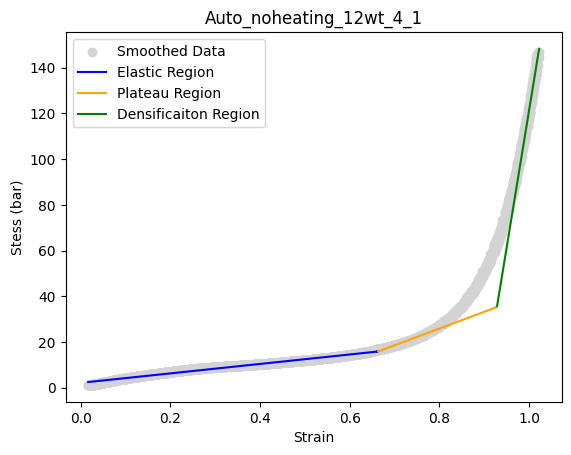

0.9301749544017737


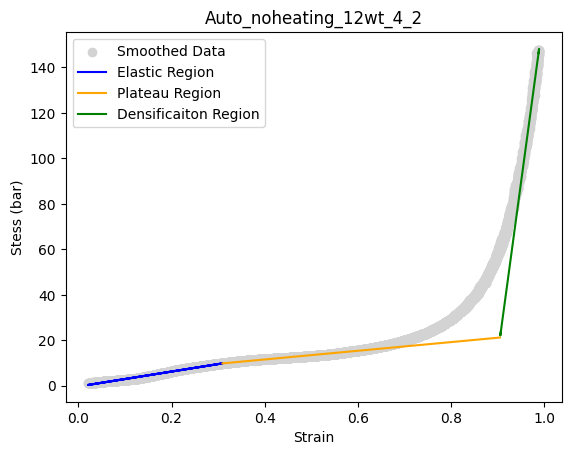

0.9213625679211483


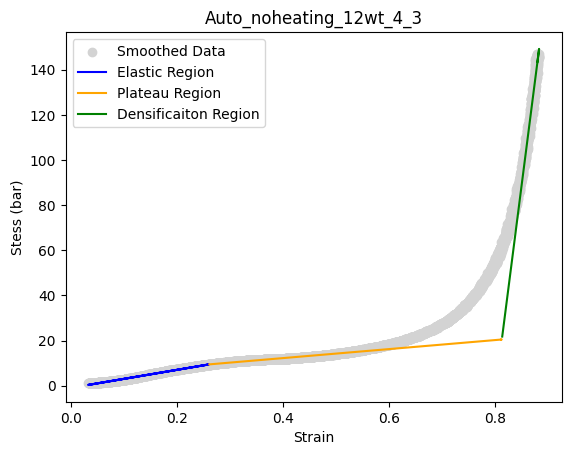

0.9190866321464864


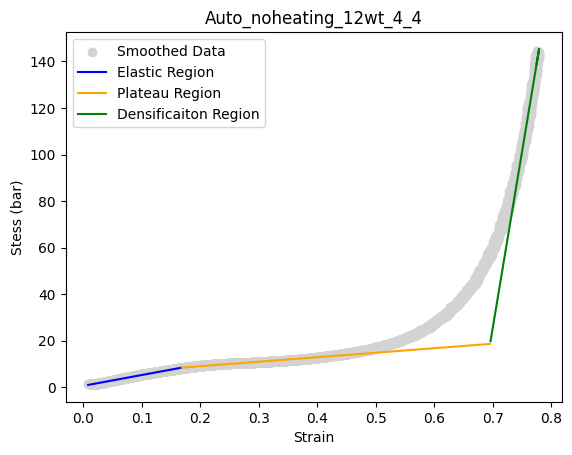

0.9568538014185413


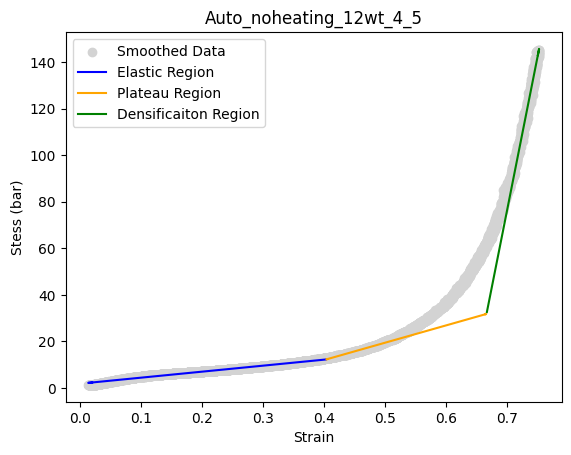

[{'Elastic Modulus': 20.674517413324697,
  'Yield Strength': array([15.84942976]),
  'Changepoint': 0.9281639532075483,
  'Slope Plateau': 73.26422111921367},
 {'Elastic Modulus': 32.89370675607006,
  'Yield Strength': array([9.80644284]),
  'Changepoint': 0.9048516478055763,
  'Slope Plateau': 19.10656391517154},
 {'Elastic Modulus': 39.873997583409974,
  'Yield Strength': array([9.47183794]),
  'Changepoint': 0.8130700737589472,
  'Slope Plateau': 19.95086135199467},
 {'Elastic Modulus': 46.4937791307026,
  'Yield Strength': array([8.40539349]),
  'Changepoint': 0.6952932165169149,
  'Slope Plateau': 19.35467102228316},
 {'Elastic Modulus': 25.750825346179386,
  'Yield Strength': array([12.26376596]),
  'Changepoint': 0.6662734222197725,
  'Slope Plateau': 74.27811345075312}]

In [128]:
Auto_noheating_12wt_4_1 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-1-240223_02232024_163339.csv')
Auto_noheating_12wt_4_2 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-2-240223_02232024_163631.csv')
Auto_noheating_12wt_4_3 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-3-240223_02232024_163935.csv')
Auto_noheating_12wt_4_4 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-4-240223_02232024_164316.csv')
Auto_noheating_12wt_4_5 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-5-240223_02232024_164618.csv') #doesn't accurately calculate Elastic Modulus

data_list_12_4 = [Auto_noheating_12wt_4_1, Auto_noheating_12wt_4_2, Auto_noheating_12wt_4_3, Auto_noheating_12wt_4_4, Auto_noheating_12wt_4_5]
thickness_12_4 = [111,108,104,104,102]

interpretData(data_list_12_4, thickness_info = True, thickness_list = thickness_12_4)

0.9220427739121028


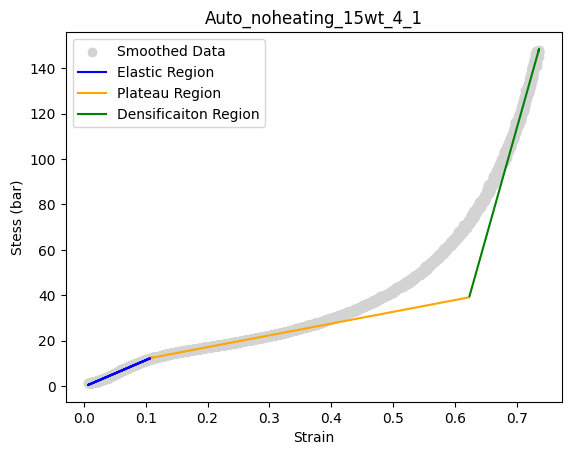

0.9318278676238732


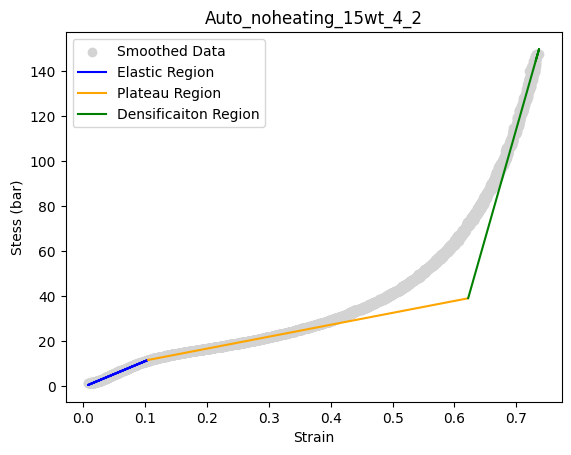

0.9347882646609487


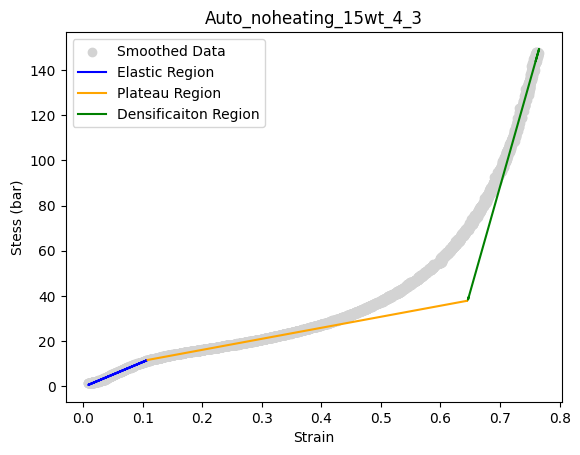

0.9383562415286666


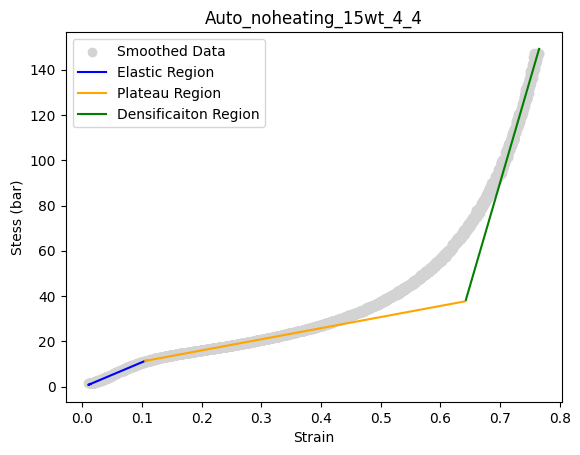

[{'Elastic Modulus': 117.22144174725625,
  'Yield Strength': array([12.3703704]),
  'Changepoint': 0.6232306175417428,
  'Slope Plateau': 51.87779032245267},
 {'Elastic Modulus': 114.70306229611774,
  'Yield Strength': array([11.67996874]),
  'Changepoint': 0.6220889473604809,
  'Slope Plateau': 52.90242102640979},
 {'Elastic Modulus': 110.87071749657605,
  'Yield Strength': array([11.63463728]),
  'Changepoint': 0.6456706455410796,
  'Slope Plateau': 48.85299147272378},
 {'Elastic Modulus': 111.32968777788143,
  'Yield Strength': array([11.31326068]),
  'Changepoint': 0.6421519095958184,
  'Slope Plateau': 49.12015530628948}]

In [129]:
Auto_noheating_15wt_4_1 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-1-240226_02262024_162514.csv')
Auto_noheating_15wt_4_2 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-2-240226_02262024_162808.csv')
Auto_noheating_15wt_4_3 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-3-240226_02262024_163110.csv')
Auto_noheating_15wt_4_4 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-4-240226_02262024_163353.csv')

data_list_15_4 = [Auto_noheating_15wt_4_1, Auto_noheating_15wt_4_2, Auto_noheating_15wt_4_3, Auto_noheating_15wt_4_4]
thickness_15_4 = [109,103,100,100]

interpretData(data_list_15_4, thickness_info = True, thickness_list = thickness_15_4)

0.8809064271408431


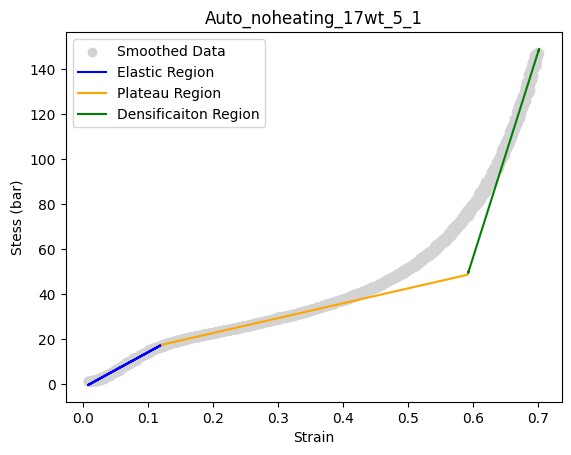

0.8836392923087972


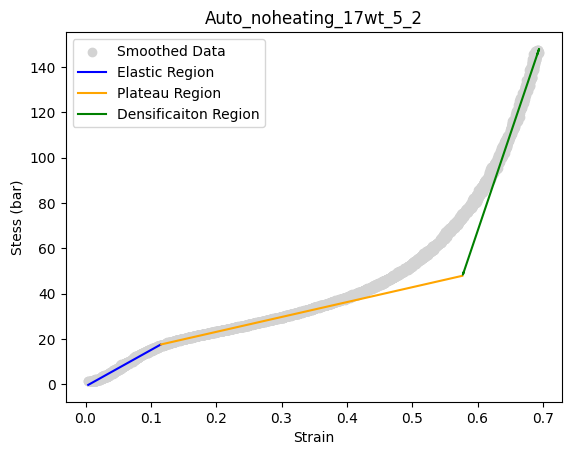

0.8905444088098283


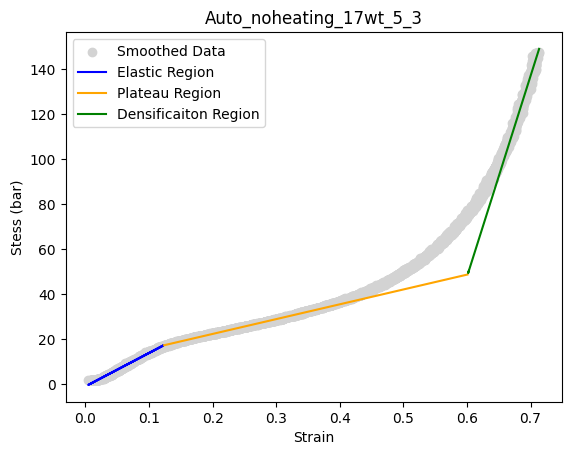

0.8913047728290155


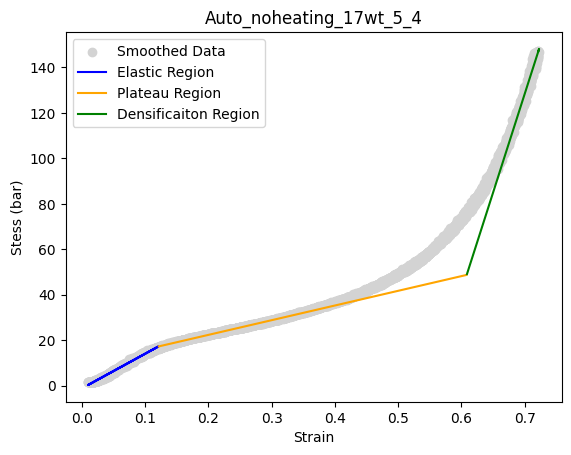

[{'Elastic Modulus': 157.60268409079663,
  'Yield Strength': array([17.55710836]),
  'Changepoint': 0.59194186573454,
  'Slope Plateau': 66.01043823183356},
 {'Elastic Modulus': 160.42909218483385,
  'Yield Strength': array([17.58354818]),
  'Changepoint': 0.5769191130342379,
  'Slope Plateau': 65.65407239872053},
 {'Elastic Modulus': 148.6353490518117,
  'Yield Strength': array([17.11422704]),
  'Changepoint': 0.6011065800827196,
  'Slope Plateau': 65.99183417586936},
 {'Elastic Modulus': 152.41042088839254,
  'Yield Strength': array([17.22293558]),
  'Changepoint': 0.6083896258493598,
  'Slope Plateau': 64.62002606511716}]

In [130]:
Auto_noheating_17wt_5_1 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-1-240223_02232024_194527.csv')
Auto_noheating_17wt_5_2 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-2-240223_02232024_194752.csv')
Auto_noheating_17wt_5_3 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-3-240223_02232024_195016.csv')
Auto_noheating_17wt_5_4 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-4-240223_02232024_195303.csv')

data_list_17_5 = [Auto_noheating_17wt_5_1, Auto_noheating_17wt_5_2, Auto_noheating_17wt_5_3, Auto_noheating_17wt_5_4]
thickness_17_5 = [107,106,101,100]

interpretData(data_list_17_5, thickness_info = True, thickness_list = thickness_17_5)

0.9303734889284486


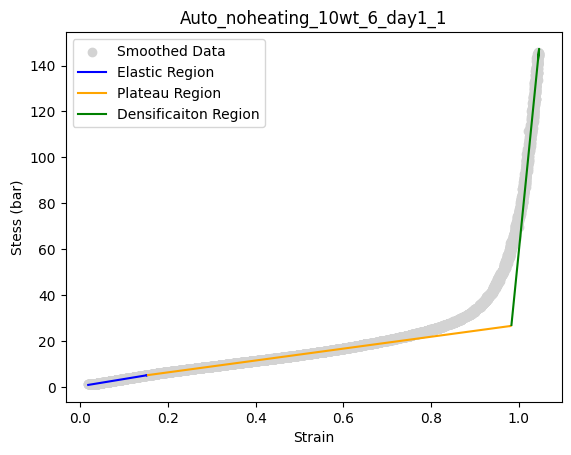

0.9412363134781335


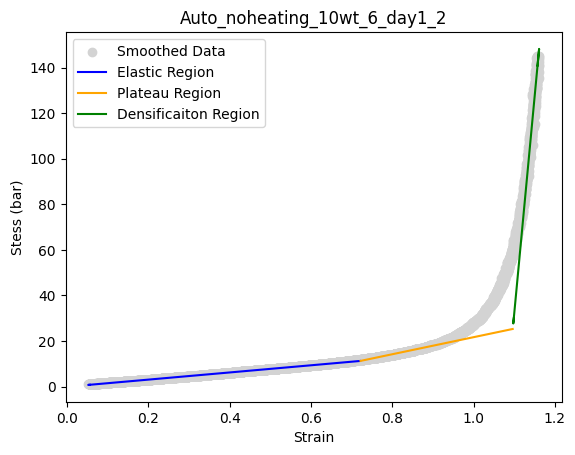

0.927429508313887


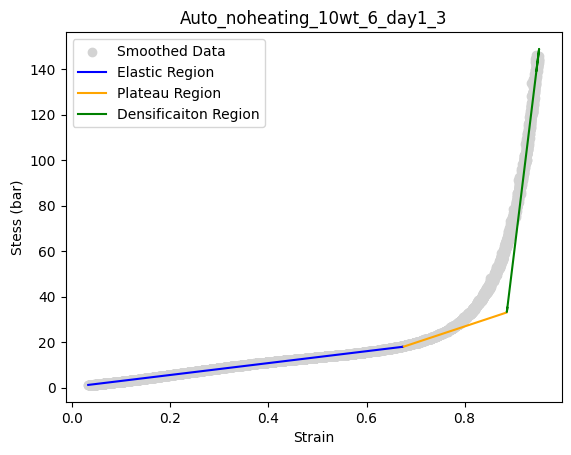

0.9358208924273996


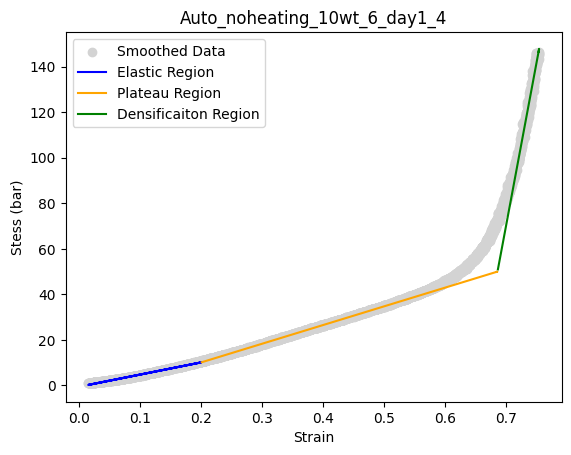

[{'Elastic Modulus': 31.432941274193098,
  'Yield Strength': array([5.30391426]),
  'Changepoint': 0.9832104279013639,
  'Slope Plateau': 25.816238832013678},
 {'Elastic Modulus': 15.72192308922559,
  'Yield Strength': array([11.2655394]),
  'Changepoint': 1.096540561794298,
  'Slope Plateau': 37.4358851527238},
 {'Elastic Modulus': 26.114933765507825,
  'Yield Strength': array([17.93447832]),
  'Changepoint': 0.8860298987252743,
  'Slope Plateau': 71.50202330999488},
 {'Elastic Modulus': 53.437893673291285,
  'Yield Strength': array([10.14559401]),
  'Changepoint': 0.6865966901410296,
  'Slope Plateau': 82.09900802961374}]

In [131]:
Auto_noheating_10wt_6_day1_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-1-240228_02282024_201331.csv')
Auto_noheating_10wt_6_day1_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-2-240228_02282024_201646.csv') #can't find Young's Modulus in og data
Auto_noheating_10wt_6_day1_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-3-240228_02282024_201943.csv') 
Auto_noheating_10wt_6_day1_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-4-240228_02282024_202246.csv') #can't find Young's Modulus in og data

data_list_10_6_day1 = [Auto_noheating_10wt_6_day1_1, Auto_noheating_10wt_6_day1_2, Auto_noheating_10wt_6_day1_3, Auto_noheating_10wt_6_day1_4]
thickness_10_6_day1 = [99, 86, 98, 120]

interpretData(data_list_10_6_day1, thickness_info = True, thickness_list = thickness_10_6_day1)

0.9117515617778913


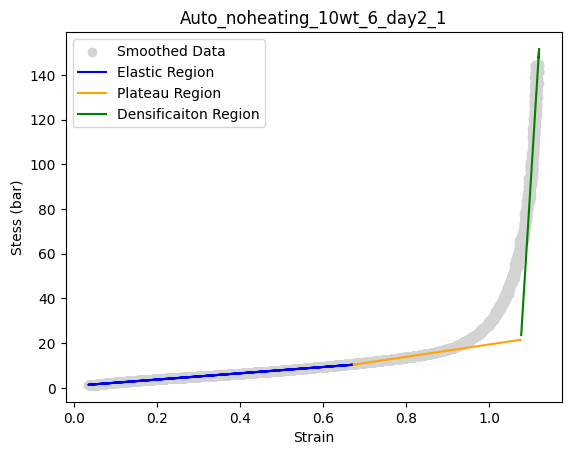

0.9014731685932251


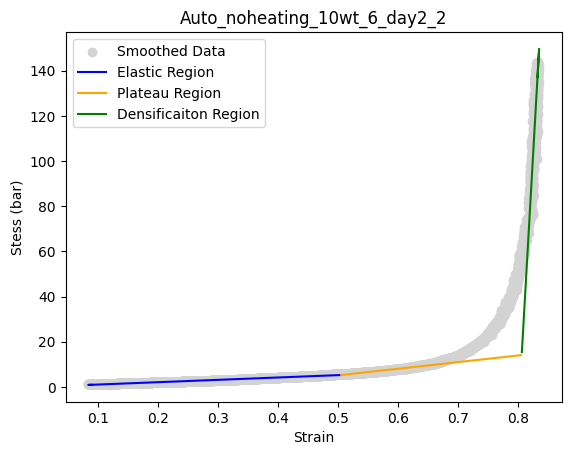

0.9168286972354095


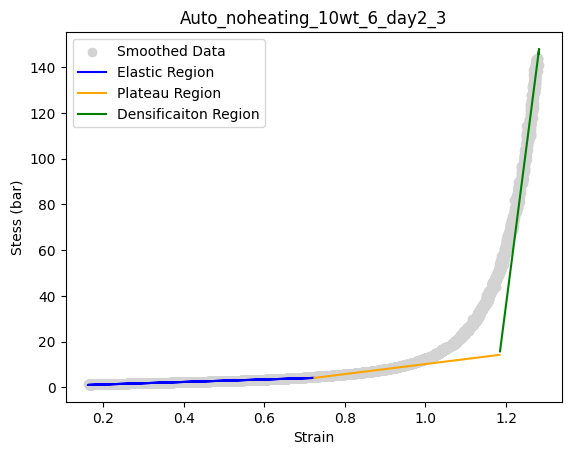

0.9347739241798829


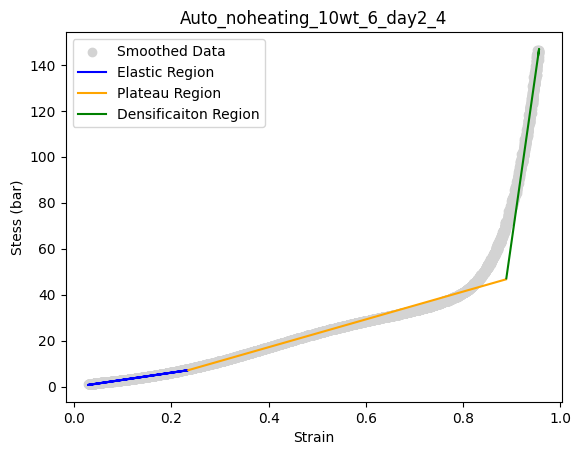

0.9114054577624633


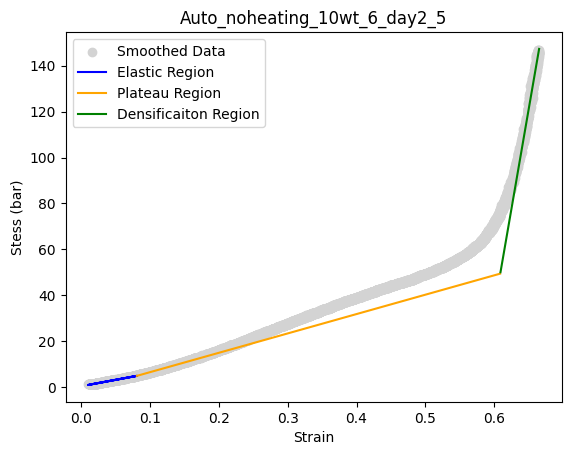

[{'Elastic Modulus': 14.080776575453415,
  'Yield Strength': array([10.33042574]),
  'Changepoint': 1.0757902664145642,
  'Slope Plateau': 27.690585412386056},
 {'Elastic Modulus': 10.392211660344943,
  'Yield Strength': array([5.256874]),
  'Changepoint': 0.8064880945939406,
  'Slope Plateau': 29.31346433712692},
 {'Elastic Modulus': 5.465132293208112,
  'Yield Strength': array([4.10657863]),
  'Changepoint': 1.1840766452555884,
  'Slope Plateau': 21.901681238169026},
 {'Elastic Modulus': 31.144861775157214,
  'Yield Strength': array([7.12695779]),
  'Changepoint': 0.8885142846280059,
  'Slope Plateau': 60.46316352309759},
 {'Elastic Modulus': 55.75141225074979,
  'Yield Strength': array([4.94443391]),
  'Changepoint': 0.6089338128154905,
  'Slope Plateau': 84.24272868597666}]

In [132]:
Auto_noheating_10wt_6_day2_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-1-240229_02292024_165802.csv') #can't find Young's Modulus in og data
Auto_noheating_10wt_6_day2_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-2-240229_02292024_170133.csv') #can't find Young's Modulus in og data
Auto_noheating_10wt_6_day2_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-3-240229_02292024_170353.csv') #can't find Young's Modulus in og data
Auto_noheating_10wt_6_day2_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-4-240229_02292024_170638.csv') #can't find Young's Modulus in og data
Auto_noheating_10wt_6_day2_5 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-5-240229_02292024_170950.csv') #can't find Young's Modulus in og data   

data_list_10_6_day2 = [Auto_noheating_10wt_6_day2_1, Auto_noheating_10wt_6_day2_2, Auto_noheating_10wt_6_day2_3, Auto_noheating_10wt_6_day2_4, Auto_noheating_10wt_6_day2_5]
thickness_10_6_day2 = [76, 76, 62, 130, 156]

interpretData(data_list_10_6_day2, thickness_info = True, thickness_list = thickness_10_6_day2)

0.9695224740155263


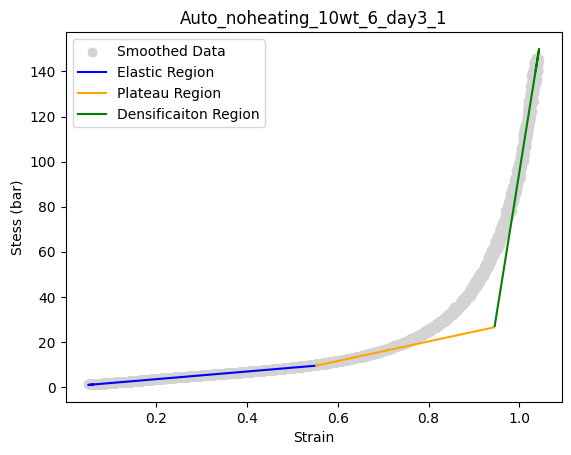

0.9673522546878616


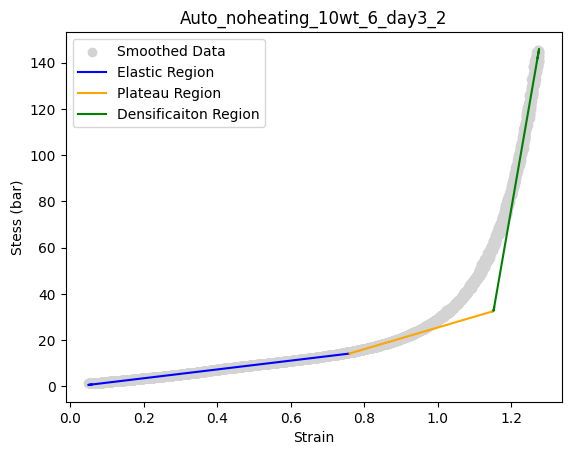

0.934418601857016


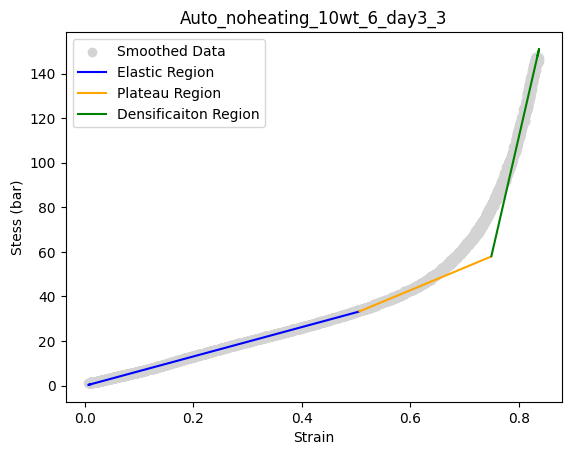

0.9516497504218897


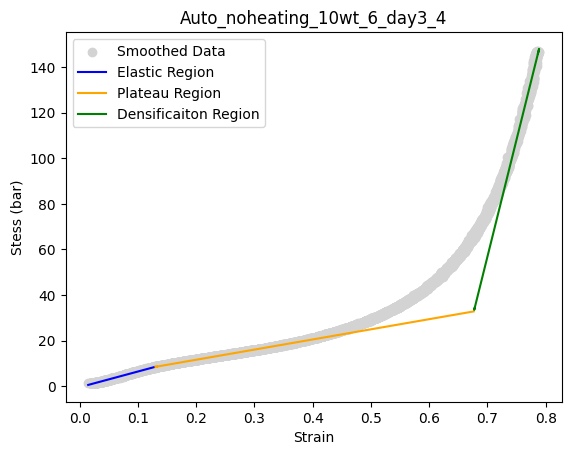

0.9525013599795317


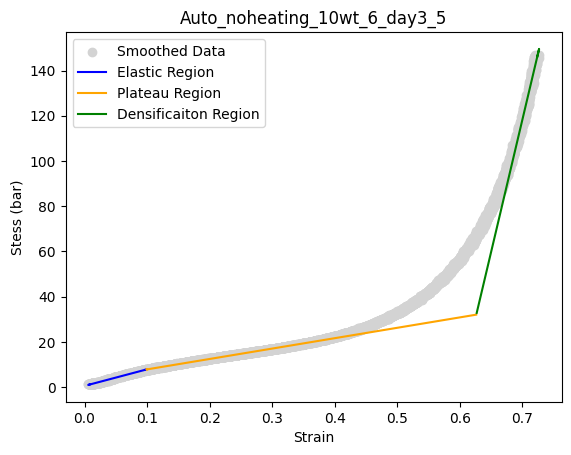

[{'Elastic Modulus': 17.019469813814787,
  'Yield Strength': array([9.44774944]),
  'Changepoint': 0.945193504851274,
  'Slope Plateau': 43.29840289888002},
 {'Elastic Modulus': 19.097092523362228,
  'Yield Strength': array([14.15016925]),
  'Changepoint': 1.15128309840085,
  'Slope Plateau': 46.89188468807031},
 {'Elastic Modulus': 65.93759179048936,
  'Yield Strength': array([33.23051782]),
  'Changepoint': 0.749271387409228,
  'Slope Plateau': 101.420515288285},
 {'Elastic Modulus': 68.97908444959924,
  'Yield Strength': array([8.45376822]),
  'Changepoint': 0.6766162620222215,
  'Slope Plateau': 44.5164385291246},
 {'Elastic Modulus': 73.36602185194155,
  'Yield Strength': array([7.79110674]),
  'Changepoint': 0.6264878196102969,
  'Slope Plateau': 45.95383311626579}]

In [133]:
Auto_noheating_10wt_6_day3_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-1-240301_03012024_155023.csv') #can't find Young's Modulus in og data
Auto_noheating_10wt_6_day3_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-2-240301_03012024_155302.csv') #can't find Young's Modulus in og data
Auto_noheating_10wt_6_day3_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-3-240301_03012024_155535.csv') #can't find Young's Modulus in og data
Auto_noheating_10wt_6_day3_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-4-240301_03012024_155819.csv')
Auto_noheating_10wt_6_day3_5 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-5-240301_03012024_160114.csv')

data_list_10_6_day3 = [Auto_noheating_10wt_6_day3_1, Auto_noheating_10wt_6_day3_2, Auto_noheating_10wt_6_day3_3, Auto_noheating_10wt_6_day3_4, Auto_noheating_10wt_6_day3_5]
thickness_10_6_day3 = [74, 76, 121, 119, 113]

interpretData(data_list_10_6_day3, thickness_info = True, thickness_list = thickness_10_6_day3)

0.894926523788057


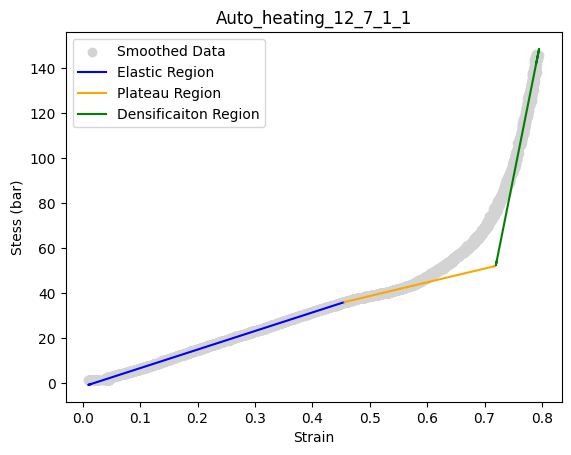

0.8809655853390318


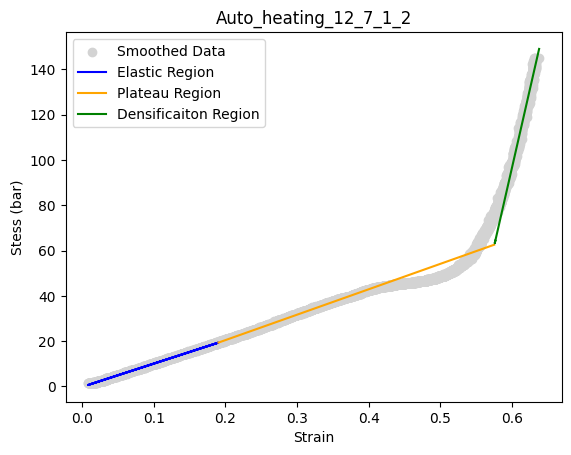

0.8792756822991591


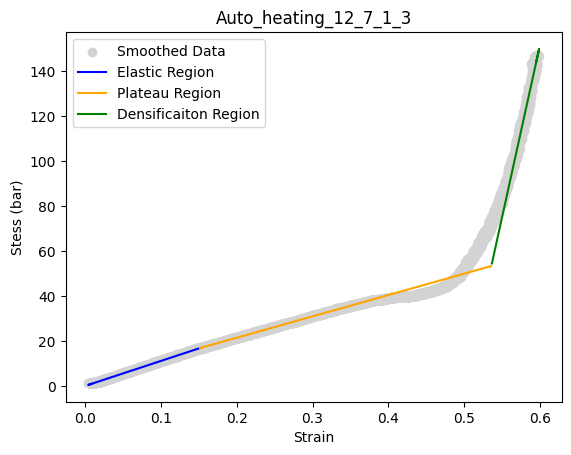

0.8514867746895795


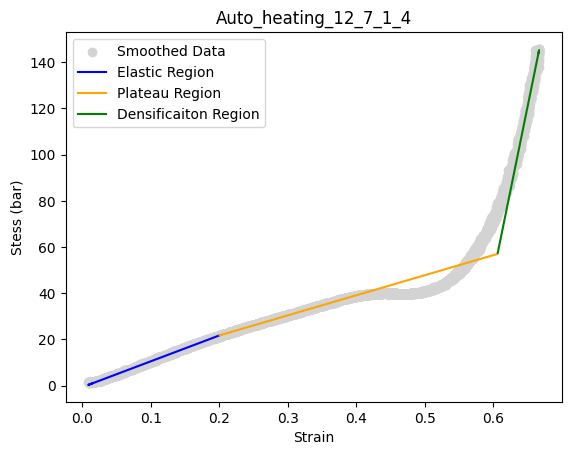

[{'Elastic Modulus': 82.55522582785193,
  'Yield Strength': array([35.96074265]),
  'Changepoint': 0.719540907111301,
  'Slope Plateau': 61.07300602138398},
 {'Elastic Modulus': 102.64738519573953,
  'Yield Strength': array([19.26705545]),
  'Changepoint': 0.5758700883257728,
  'Slope Plateau': 112.12370518112328},
 {'Elastic Modulus': 111.27101261837385,
  'Yield Strength': array([16.77667838]),
  'Changepoint': 0.5354993766198478,
  'Slope Plateau': 94.9742749857217},
 {'Elastic Modulus': 111.9734123375528,
  'Yield Strength': array([21.72909033]),
  'Changepoint': 0.6060219885278232,
  'Slope Plateau': 86.95107717238808}]

In [134]:
Auto_heating_12_7_1_1 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-1-240320_03202024_202947.csv') #can't find Young's Modulus in og data
Auto_heating_12_7_1_2 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-2-240320_03202024_203323.csv') #can't find Young's Modulus in og data
Auto_heating_12_7_1_3 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-3-240320_03202024_203606.csv') #can't find Young's Modulus in og data
Auto_heating_12_7_1_4 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-4-240320_03202024_203910.csv') #can't find Young's Modulus in og data

data_list_12_7_1 = [Auto_heating_12_7_1_1, Auto_heating_12_7_1_2, Auto_heating_12_7_1_3, Auto_heating_12_7_1_4]
thickness_12_7_1 = [115, 122, 125, 125]

interpretData(data_list_12_7_1, thickness_info = True, thickness_list = thickness_12_7_1)

0.8637909772905374


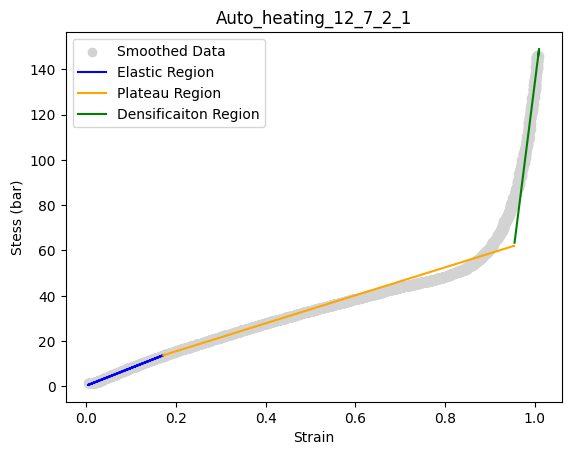

0.913735789425201


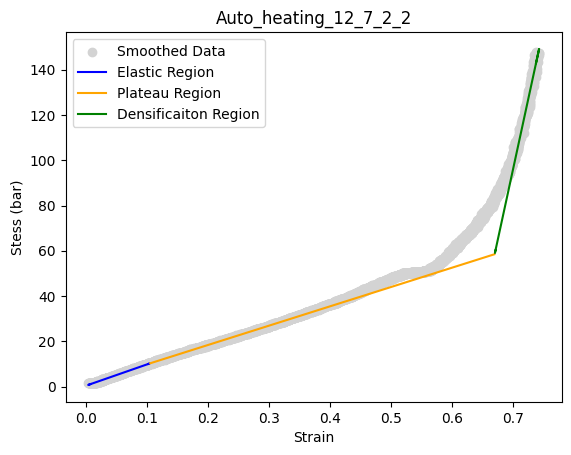

0.9079255218840583


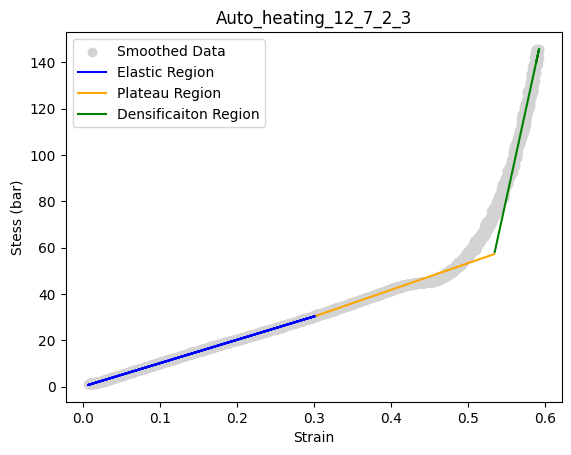

0.8909188143430493


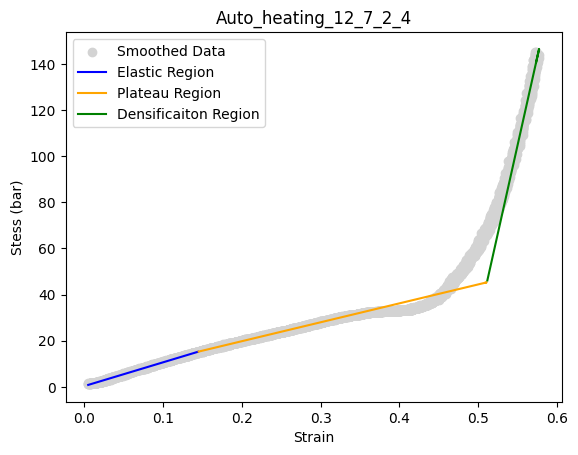

[{'Elastic Modulus': 78.19489701865722,
  'Yield Strength': array([13.73061036]),
  'Changepoint': 0.9542078397937425,
  'Slope Plateau': 61.716052215630526},
 {'Elastic Modulus': 94.23179076806201,
  'Yield Strength': array([10.22436484]),
  'Changepoint': 0.6694876742379008,
  'Slope Plateau': 85.50570981329777},
 {'Elastic Modulus': 100.81600757757197,
  'Yield Strength': array([30.67424031]),
  'Changepoint': 0.5336737935750128,
  'Slope Plateau': 115.18348221961698},
 {'Elastic Modulus': 103.31257963813337,
  'Yield Strength': array([15.25966497]),
  'Changepoint': 0.5107738674553107,
  'Slope Plateau': 82.21972313235005}]

In [135]:
Auto_heating_12_7_2_1 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-1-240320_03202024_204415.csv') #can't find Young's Modulus in og data
Auto_heating_12_7_2_2 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-2-240320_03202024_204706.csv') #can't find Young's Modulus in og data
Auto_heating_12_7_2_3 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-3-240320_03202024_204950.csv') #can't find Young's Modulus in og data
Auto_heating_12_7_2_4 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-4-240320_03202024_205221.csv') #can't find Young's Modulus in og data

data_list_12_7_2 = [Auto_heating_12_7_2_1, Auto_heating_12_7_2_2, Auto_heating_12_7_2_3, Auto_heating_12_7_2_4]
thickness_12_7_2 = [108,112,116,115]

interpretData(data_list_12_7_2, thickness_info = True, thickness_list = thickness_12_7_2)

0.8830936837189032


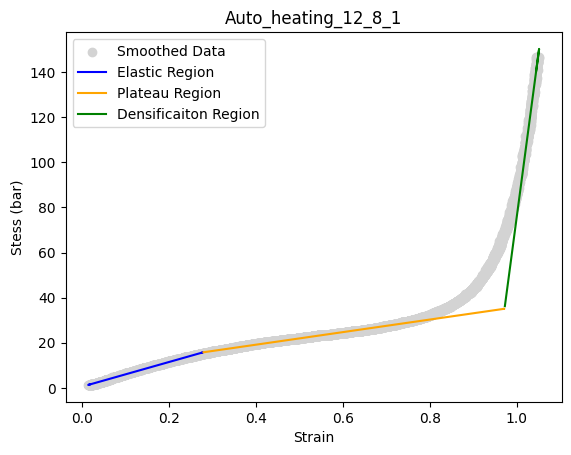

0.9211560825358553


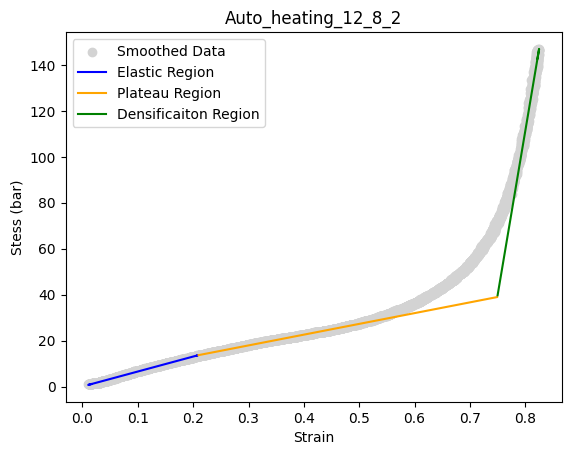

0.9078887489331955


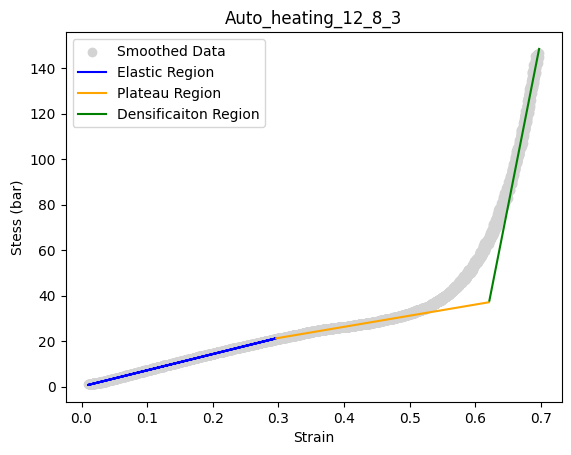

0.9073120592130108


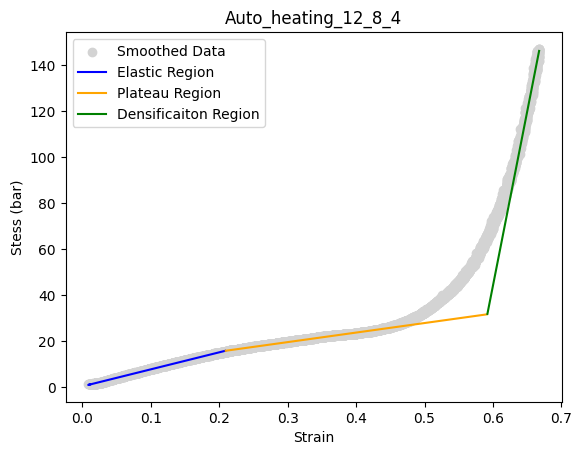

[{'Elastic Modulus': 54.7113804816087,
  'Yield Strength': array([15.75574432]),
  'Changepoint': 0.9717680481935667,
  'Slope Plateau': 27.877161235855187},
 {'Elastic Modulus': 65.12872625790715,
  'Yield Strength': array([13.64500371]),
  'Changepoint': 0.7493824668440777,
  'Slope Plateau': 46.85217663939884},
 {'Elastic Modulus': 71.5064606186145,
  'Yield Strength': array([21.26791529]),
  'Changepoint': 0.62087941535594,
  'Slope Plateau': 48.945357103362156},
 {'Elastic Modulus': 73.99132737829221,
  'Yield Strength': array([15.83697283]),
  'Changepoint': 0.5917469736526374,
  'Slope Plateau': 41.44810925255371}]

In [136]:
Auto_heating_12_8_1 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-1-240328_03282024_152144.csv')
Auto_heating_12_8_2 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-2-240328_03282024_152416.csv')
Auto_heating_12_8_3 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-3-240328_03282024_152657.csv')
Auto_heating_12_8_4 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-4-240328_03282024_152944.csv')

data_list_12_8 = [Auto_heating_12_8_1, Auto_heating_12_8_2, Auto_heating_12_8_3, Auto_heating_12_8_4]
thickness_12_8 = [100,105,110,116]

interpretData(data_list_12_8, thickness_info = True, thickness_list = thickness_12_8)

0.8857474058675148


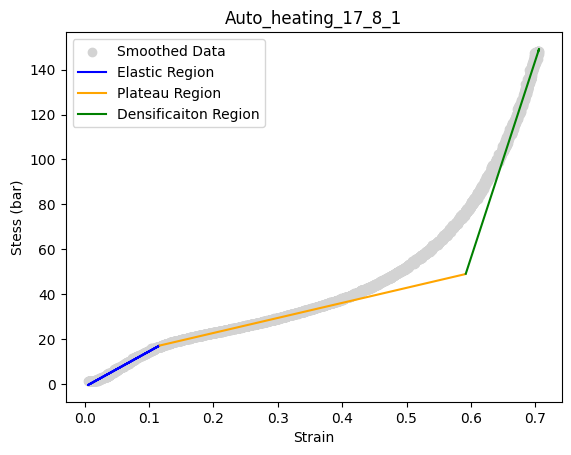

0.8848025221994289


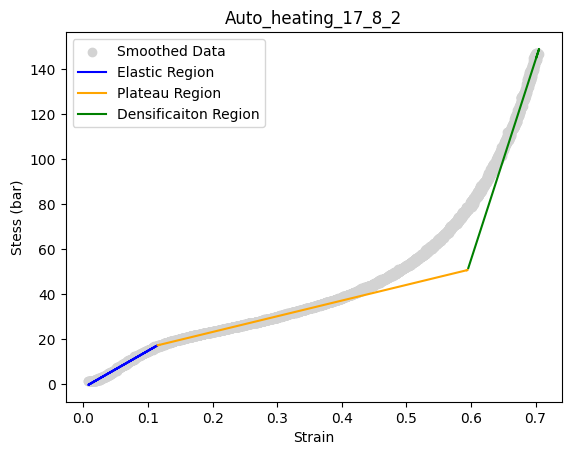

0.8781680331680493


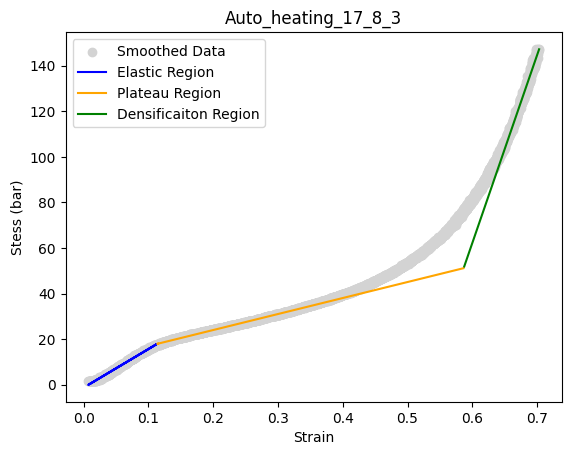

0.8774527400320031


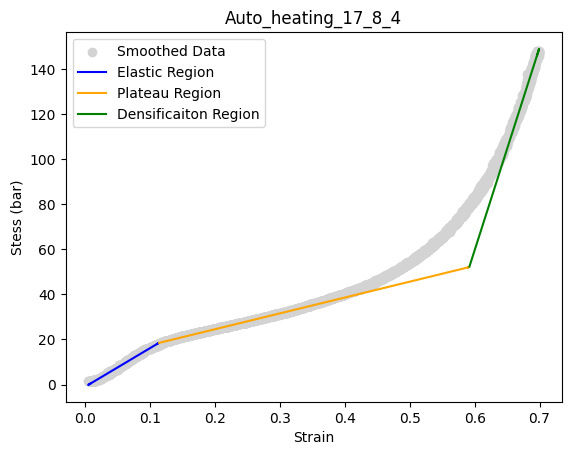

[{'Elastic Modulus': 157.96587565975364,
  'Yield Strength': array([17.18339339]),
  'Changepoint': 0.5919327135832287,
  'Slope Plateau': 66.94305494235536},
 {'Elastic Modulus': 163.72408459455573,
  'Yield Strength': array([17.3229092]),
  'Changepoint': 0.5949518927856005,
  'Slope Plateau': 69.62523966137161},
 {'Elastic Modulus': 169.3158246984652,
  'Yield Strength': array([17.93115276]),
  'Changepoint': 0.5866447744691164,
  'Slope Plateau': 70.22076790694942},
 {'Elastic Modulus': 171.35348156968814,
  'Yield Strength': array([18.45070105]),
  'Changepoint': 0.5916135193912894,
  'Slope Plateau': 70.33785738049056}]

In [137]:
Auto_heating_17_8_1 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-1-240328_03282024_153404.csv')
Auto_heating_17_8_2 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-2-240328_03282024_153634.csv')
Auto_heating_17_8_3 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-3-240328_03282024_153853.csv')
Auto_heating_17_8_4 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-4-240328_03282024_154142.csv')

data_list_17_8 = [Auto_heating_17_8_1, Auto_heating_17_8_2, Auto_heating_17_8_3, Auto_heating_17_8_4]
thickness_17_8 = [103,104,107,109]

interpretData(data_list_17_8, thickness_info = True, thickness_list = thickness_17_8)

0.8631541568200622


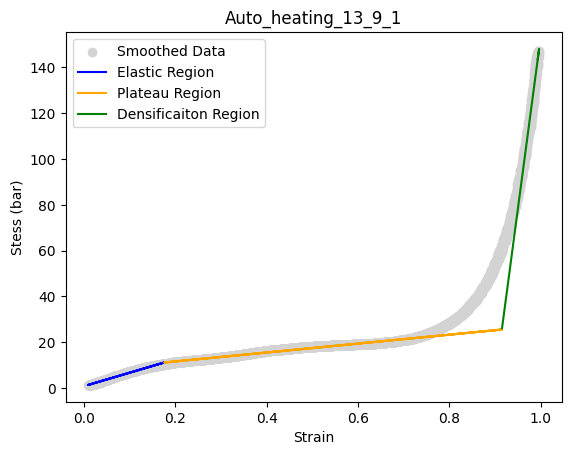

0.8516679764154935


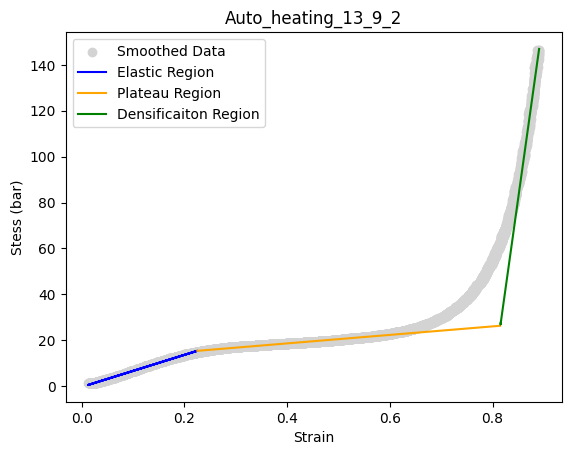

0.8487600851400209


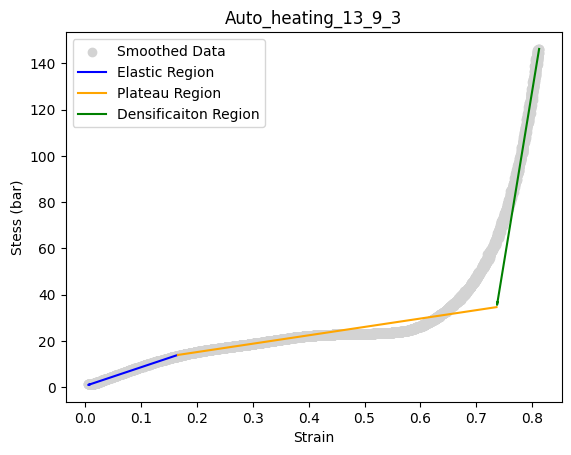

0.8926886600538549


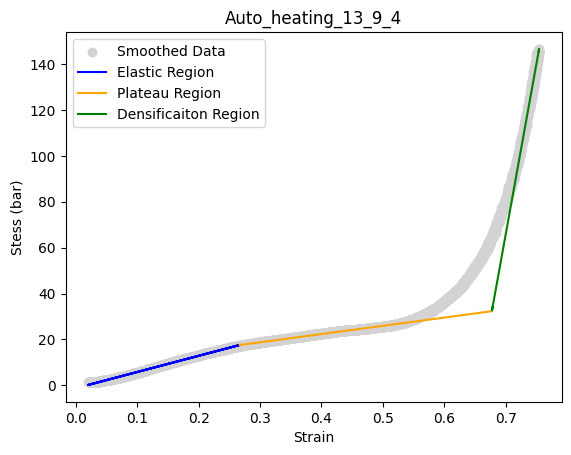

[{'Elastic Modulus': 58.84312535048405,
  'Yield Strength': array([11.08228815]),
  'Changepoint': 0.914878850773767,
  'Slope Plateau': 19.472535950350643},
 {'Elastic Modulus': 69.95415316491537,
  'Yield Strength': array([15.34980491]),
  'Changepoint': 0.8152102046308102,
  'Slope Plateau': 18.536591234192024},
 {'Elastic Modulus': 80.94596671970996,
  'Yield Strength': array([13.91178444]),
  'Changepoint': 0.7361473997351113,
  'Slope Plateau': 36.29970085433052},
 {'Elastic Modulus': 70.49969125847556,
  'Yield Strength': array([17.56713934]),
  'Changepoint': 0.6776087212483789,
  'Slope Plateau': 35.870151792099435}]

In [138]:
Auto_heating_13_9_1 = pd.read_csv('Data/compression 9/AutoHeating-13-9-1--240404_04042024_173756.csv')
Auto_heating_13_9_2 = pd.read_csv('Data/compression 9/AutoHeating-13-9-2--240404_04042024_174116.csv')
Auto_heating_13_9_3 = pd.read_csv('Data/compression 9/AutoHeating-13-9-3--240404_04042024_174359.csv')  
Auto_heating_13_9_4 = pd.read_csv('Data/compression 9/AutoHeating-13-9-4--240404_04042024_174655.csv')

data_list_13_9 = [Auto_heating_13_9_1, Auto_heating_13_9_2, Auto_heating_13_9_3, Auto_heating_13_9_4]  
thickness_13_9 = [112,121,125,137]

interpretData(data_list_13_9, thickness_info = True, thickness_list = thickness_13_9)